In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import metapack as mp
from pathlib import Path
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import OLS
import seaborn as sns
import json

%run ./lib.py

In [2]:
import metapack as mp
pkg = mp.open_package('http://library.metatab.org/federalreserve.gov-consumer_finances-2016-inherit-1.1.1.csv')
pkg

# Survey of Consumer Finances, Inheritance Extract
`federalreserve.gov-consumer_finances-2016-inherit-1.1.1` Last Update: 2020-10-21T04:21:11

_An Extract from the survey of consumer finances for studying networth and ineritance_


## Documentation Links

* [Documentation Page](http://library.metatab.org/federalreserve.gov-consumer_finances-2016-inherit-1.1.1/index.html) 

 
## Images

[![doc_img](http://library.metatab.org/federalreserve.gov-consumer_finances-2016-inherit-1.1.1/docs/networth_race_inc.png "networth_race_inc")](http://library.metatab.org/federalreserve.gov-consumer_finances-2016-inherit-1.1.1/docs/networth_race_inc.png)

Net Worth by Income Percentile and Race
## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [inherit_scf_16](http://library.metatab.org/federalreserve.gov-consumer_finances-2016-inherit-1.1.1/data/inherit_scf_16.csv)**. Extract of the 2016 SCF for inheritance and networth

## References
<ul><li> <strong><a href="https://www.federalreserve.gov/econres/files/scf2016s.zip#p16i6.dta">scf_public_16</a></strong>. Survey of consumer finances, full public dataset, 2016</li><li> <strong><a href="https://www.federalreserve.gov/econres/files/scfp2016s.zip#rscfp2016.dta">scf_extract_16</a></strong>. Survey of consumer finances, public extract, 2016</li><li> <strong><a href="https://www.federalreserve.gov/econres/files/scf2016rw1s.zip#p16_rw1.dta">scf_weights_16</a></strong>. Survey of consumer finances, replicate weights, 2016</li><ul>

In [3]:
# Create Dataframes
df = pkg.resource('inherit_scf_16').dataframe()

In [4]:
d = '/Users/eric/proj/data-projects/insights/survey_consumer_finances/federalreserve.gov-consumer_finances-2016-inherit/data/'
df = pd.read_csv(d+'inherit_scf_16.csv')

df.head()

#with open('categoricals.json') as f:
#    categoricals = json.load(f)
    
#for c in categoricals:
#    df[c] = df[c].astype('category')
    
df.head()

,case_id,record_id,implicate_id,age_1,age_2,hisp,race,addtional_race,unusual_income,ed_1,...,nwpctle,n_gift,n_inherit,n_trust,n_transfer,any_transfer,any_inherit,hhsize,networthpc,assetpc
0,1,11,1,71,0,5,white,5,3,assoc_vocational,...,60,0,0,0,0,0,0,1,187954.520394,188358.677918
1,1,12,2,71,0,5,white,5,3,assoc_vocational,...,60,0,0,0,0,0,0,1,188071.513361,188465.035162
2,1,13,3,71,0,5,white,5,3,assoc_vocational,...,60,0,0,0,0,0,0,1,187965.156118,188358.677918
3,1,14,4,71,0,5,white,5,3,assoc_vocational,...,60,0,0,0,0,0,0,1,187965.156118,188358.677918
4,1,15,5,71,0,5,white,5,3,assoc_vocational,...,60,0,0,0,0,0,0,1,188071.513361,188465.035162


In [5]:
# Get the extract and pull out a few more variables
#scfe = pkg.reference('scf_extract').dataframe().rename(columns={'Y1': 'record_id'})
#scfe.columns = [c.lower() for c in scfe.columns]
#df = df.merge(scfe, on='record_id', suffixes=('','_other') )


In [6]:
#dfs = make_sample(df, N=200_000, extra_cols=[
#    'occ','occ_1', 'nincpctlecat','nwpctlecat', 'racecl','debt', 'spend_exceeds', 'saved', 'lt_planner', 'homeeq', 'debt2inc',
#    'fin_risk', 'fin_know','borrow_vacation', 'spend_exceeds_excl_house'])

#dfs['hhsize'] = df.married.apply( lambda v: 1 if v ==2 else 2)
#dfs['networthpc'] = dfs.networth / dfs.hhsize
#dfs['assetpc'] = dfs.asset / dfs.hhsize

dfs = df.sample(500_000, replace=True, weights=df.wt0)

# Create quantiles for gi_sum
o, gi_sum_bins = pd.qcut(dfs[dfs.gi_sum > 0].gi_sum, 10 , retbins = True)
gi_sum_bins[0] = 0 # So zero gets included in a bin
dfs['gi_sum_decile']  = pd.cut(dfs.gi_sum, gi_sum_bins, labels=False).fillna(0)

dfs.head()

,case_id,record_id,implicate_id,age_1,age_2,hisp,race,addtional_race,unusual_income,ed_1,...,n_gift,n_inherit,n_trust,n_transfer,any_transfer,any_inherit,hhsize,networthpc,assetpc,gi_sum_decile
7923,1589,15894,4,85,84,5,white,5,2,grade_1_4,...,0,0,0,0,0,0,2,78092.805907,78092.805907,0.0
16532,3314,33143,3,25,25,5,white,5,2,hs,...,1,0,0,1,1,0,2,68068.635724,68068.635724,6.0
26718,5355,53554,4,42,51,5,black,5,3,grade_7_8,...,0,1,0,1,1,1,2,2127.144866,2127.144866,0.0
8110,1627,16271,1,52,51,5,white,5,3,assoc_vocational,...,0,0,0,0,0,0,2,32917.566807,87691.547117,0.0
3457,695,6953,3,51,47,5,other,5,3,grade_7_8,...,0,0,0,0,0,0,2,9838.045007,15687.693390,0.0


family structure: 
* 1=not married/LWP + children, 
* 2=not married/LWP + no children + head under 55, 
* 3=not married/LWP + no children + head 55 or older, 
* 4=married/LWP + children
* 5=married/LWP + no children;

In [7]:
t=dfs.groupby(['occ_1','race']).norminc.count().to_frame().reset_index()
pd.crosstab(t.occ_1 ,t.race, t.norminc, aggfunc=np.sum, margins=True, normalize='index')

race,black,hisp,other,white
occ_1,,,,
0,0.171381,0.082498,0.041294,0.704826
1,0.126494,0.072526,0.068264,0.732715
2,0.196152,0.117388,0.049591,0.636869
3,0.216716,0.197590,0.038317,0.547376
4,0.084259,0.223528,0.028058,0.664155
5,0.200509,0.159491,0.034337,0.605663
6,0.051463,0.216227,0.020336,0.711973
All,0.158468,0.114176,0.047784,0.679572


In [8]:
dfs[dfs.nincpctlecat <=10].groupby('occ_1').norminc.median()

occ_1
0    37705.151694
1    89415.074018
2    58173.662614
3    43091.601936
4    61405.532759
5    54941.792469
6    53864.502421
Name: norminc, dtype: float64

In [9]:
dfs[dfs.nincpctlecat <=10].groupby(['occ','agecl']).norminc.median().unstack().T.round(0)

occ,1,2,3,4,5,6,7
agecl,,,,,,,
35-44,93724.0,64637.0,43092.0,49555.0,48478.0,37705.0,24778.0
45-54,103420.0,64637.0,44169.0,49555.0,48478.0,45246.0,23700.0
55-64,100188.0,66706.0,37705.0,65715.0,54942.0,59251.0,26932.0
65-74,95879.0,73256.0,37705.0,75410.0,45246.0,49803.0,42014.0
<35,66792.0,40937.0,35551.0,38782.0,33396.0,29087.0,19391.0
>=75,84029.0,48478.0,43576.0,48478.0,45246.0,34473.0,38782.0


In [10]:
dfs[dfs.nincpctlecat <=10].groupby(['famstruct','nincpctlecat']).networth.median().unstack().T

famstruct,1,2,3,4,5
nincpctlecat,,,,,
1,5.328498e+03,4.041575e+02,8.551122e+03,4403.189873,1.289050e+04
2,5.105148e+03,2.765288e+03,5.899636e+04,10103.938115,3.871404e+04
3,1.064636e+04,7.774714e+03,1.223108e+05,14996.371308,8.010828e+04
4,2.146289e+04,1.531544e+04,1.687039e+05,18187.088608,7.881072e+04
5,3.978824e+04,4.328740e+04,2.799642e+05,40543.381153,1.310321e+05
6,8.410731e+04,6.030456e+04,3.636354e+05,73099.333333,1.428271e+05
7,1.159507e+05,9.100989e+04,3.667198e+05,98167.735584,2.387720e+05
8,1.708097e+05,1.935702e+05,4.897751e+05,144645.850914,2.911955e+05
9,2.955668e+05,3.422789e+05,1.209282e+06,329813.811533,6.178292e+05


In [11]:
t.loc[:, t.dtypes ==  pd.core.arrays.integer.Int64Dtype].columns

Index(['race'], dtype='object')

In [12]:
t = dfs.dropna().copy()

t = t[t.nwpctlecat <=10 ]

for c in dfs.loc[:, dfs.dtypes == np.float64].columns:
    t[c] = t[c].astype(float)

for c in  t.loc[:, t.dtypes ==  pd.core.arrays.integer.Int64Dtype].columns:
    try:
        t[c] = t[c].astype(int)
    except:
        pass

# Why are these not caught by the prior conversions?
#for c in ['agecl', 'housecl', 'famstruct', 'indcat', 'edcl', 'occ', 'nwpctlecat', 'racecl']:
#    t[c] = t[c].astype(int)
 
t['debt_ihs'] = np.arcsinh(t.debt)
t['asset_ihs'] = np.arcsinh(t.asset)
t['assetpc_ihs'] = np.arcsinh(t.assetpc)
t['networth_ihs'] = np.arcsinh(t.networth)
t['networthpc_ihs'] = np.arcsinh(t.networthpc)
t['norminc_ihs'] = np.arcsinh(t.norminc)
t['gi_sum_ihs'] = np.arcsinh(t.gi_sum.astype(float))

t['nwrank'] = t.networth.rank().astype(int)
t['nincrank'] = t.norminc.rank().astype(int)
t['girank'] = t.gi_sum.rank()

regr = t # [t.networth > 0] # t[(t.agecl==3) & (t.housecl==1) & (t.famstruct==4)]



regr.to_csv('regression_set.csv')

In [13]:
m = ols('asset_ihs ~ norminc_ihs + gi_sum_ihs + C(racecl) + C(agecl) + C(housecl) + C(famstruct) + C(edcl) + C(occ) ',
        data=regr).fit()

m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              asset_ihs   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                 3.804e+04
Date:                Thu, 17 Dec 2020   Prob (F-statistic):               0.00
Time:                        08:02:28   Log-Likelihood:            -8.6136e+05
No. Observations:              474911   AIC:                         1.723e+06
Df Residuals:                  474888   BIC:                         1.723e+06
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   4.7153      0.040    117.472      0.000       4.637       4.794
C(racecl)[T.2]             -0.2644      0.005    -54.896      0.000      -0.274      -0.255
C(agecl)[T.45-54]           0.1707      0.007     23.516      0.000       0.156       0.185
C(agecl)[T.55-64]           0.3390      0.008     41.112      0.000       0.323       0.355
C(agecl)[T.65-74]           0.6886      0.010     70.909      0.000       0.670       0.708
C(agecl)[T.<35]            -0.0925      0.007    -12.796      0.000      -0.107      -0.078
C(agecl)[T.>=75]            0.9500      0.011     88.287      0.000       0.929       0.971
C(housecl)[T.2]            -2.5649      0.005   -488.019      0.000      -2.575      -2.555
C(famstruct)[T.2]           0.1179      0.009     13.681      0.000       0.101       0.135
C(famstruct)[T.3]          -0.0525      0.009     -5.731      0.000      -0.070      -0.035
C(famstruct)[T.4]           0.2568      0.008     33.257      0.000       0.242       0.272
C(famstruct)[T.5]           0.1358      0.008     16.926      0.000       0.120       0.152
C(edcl)[T.HS/GED]          -0.4964      0.006    -78.792      0.000      -0.509      -0.484
C(edcl)[T.No HS]           -0.9497      0.008   -115.381      0.000      -0.966      -0.934
C(edcl)[T.Some College]    -0.3012      0.006    -50.699      0.000      -0.313      -0.290
C(occ)[T.2]                -0.1997      0.007    -29.047      0.000      -0.213      -0.186
C(occ)[T.3]                -0.2128      0.008    -25.202      0.000      -0.229      -0.196
C(occ)[T.4]                -0.2928      0.010    -28.752      0.000      -0.313      -0.273
C(occ)[T.5]                -0.3533      0.011    -31.295      0.000      -0.375      -0.331
C(occ)[T.6]                 0.2067      0.028      7.395      0.000       0.152       0.262
C(occ)[T.7]                -0.6568      0.007    -88.847      0.000      -0.671      -0.642
norminc_ihs                 0.7418      0.003    231.477      0.000       0.736       0.748
gi_sum_ihs                  0.0330      0.001     65.928      0.000       0.032       0.034
==============================================================================
Omnibus:                   246103.546   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3809638.950
Skew:                          -2.136   Prob(JB):                         0.00
Kurtosis:                      16.201   Cond. No.                         226.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:

m = ols('asset_ihs ~ norminc_ihs + gi_sum_ihs + C(edcl) + C(agecl) + C(married) + C(lt_planner) + C(occat1) + C(spend_exceeds) + C(housecl)',
        data=regr).fit()

m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              asset_ihs   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                 4.708e+04
Date:                Thu, 17 Dec 2020   Prob (F-statistic):               0.00
Time:                        08:02:38   Log-Likelihood:            -8.5944e+05
No. Observations:              474911   AIC:                         1.719e+06
Df Residuals:                  474892   BIC:                         1.719e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   4.5524      0.040    112.623      0.000       4.473       4.632
C(edcl)[T.HS/GED]          -0.5521      0.006    -91.795      0.000      -0.564      -0.540
C(edcl)[T.No HS]           -1.0412      0.008   -132.817      0.000      -1.057      -1.026
C(edcl)[T.Some College]    -0.3522      0.006    -61.264      0.000      -0.364      -0.341
C(agecl)[T.45-54]           0.1392      0.007     19.286      0.000       0.125       0.153
C(agecl)[T.55-64]           0.2330      0.007     31.154      0.000       0.218       0.248
C(agecl)[T.65-74]           0.4818      0.009     51.797      0.000       0.464       0.500
C(agecl)[T.<35]            -0.0693      0.007     -9.714      0.000      -0.083      -0.055
C(agecl)[T.>=75]            0.7310      0.010     70.824      0.000       0.711       0.751
C(married)[T.2]            -0.2322      0.005    -46.755      0.000      -0.242      -0.222
C(lt_planner)[T.1]          0.2216      0.005     48.094      0.000       0.213       0.231
C(occat1)[T.2]              0.4626      0.008     60.162      0.000       0.448       0.478
C(occat1)[T.3]             -0.2819      0.007    -38.944      0.000      -0.296      -0.268
C(occat1)[T.4]             -0.5793      0.010    -58.288      0.000      -0.599      -0.560
C(spend_exceeds)[T.2]      -0.0562      0.006     -9.113      0.000      -0.068      -0.044
C(spend_exceeds)[T.3]       0.1783      0.006     28.984      0.000       0.166       0.190
C(housecl)[T.2]            -2.5650      0.005   -492.228      0.000      -2.575      -2.555
norminc_ihs                 0.7420      0.003    234.266      0.000       0.736       0.748
gi_sum_ihs                  0.0357      0.000     71.999      0.000       0.035       0.037
==============================================================================
Omnibus:                   248934.558   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3828344.939
Skew:                          -2.172   Prob(JB):                         0.00
Kurtosis:                      16.213   Cond. No.                         228.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
dfs[(dfs.nincpctlecat<=9)&(dfs.spend_exceeds==3)].groupby(['occ','race']).norminc.mean().unstack()

race,black,hisp,other,white
occ,,,,
1,84933.166331,86738.416926,93301.482917,96156.483320
2,64065.196750,66352.180387,57137.886384,78733.360245
3,50543.987048,44180.500395,65571.211091,57056.383426
4,51822.687441,49776.613606,46517.142203,67872.458627
5,62821.990966,54909.942154,51113.793443,61631.426547
6,NaN,28009.541259,161593.507262,82073.132971
7,38420.650218,34457.581753,68203.556401,56638.246195


In [16]:
dfs[dfs.nincpctlecat<=10].groupby(['lt_planner','nincpctlecat']).networth.median().unstack().T

lt_planner,0,1
nincpctlecat,,
1,2935.459916,6.562242e+03
2,6647.327707,2.818573e+04
3,18803.960619,3.815141e+04
4,20708.818847,5.137055e+04
5,46745.072011,1.229490e+05
6,79980.646976,1.156103e+05
7,67005.063291,2.116509e+05
8,162301.153305,2.136398e+05
9,280464.050633,4.881797e+05


In [17]:
'asset_ihs ~ norminc_ihs + gi_sum_ihs + C(racecl) + C(agecl) + C(housecl) + C(famstruct) + C(edcl) + C(occ) '

dep_col = 'asset_ihs'
ob_cols = ['norminc_ihs', 'gi_sum_ihs', 'racecl']

t = regr.copy()
#t['racecl'] = (t.racecl-1).astype('uint8')

for c in 'agecl housecl famstruct edcl occ borrow_vacation spend_exceeds_excl_house fin_risk fin_know'.split():
    t[c] = t[c].astype('category')
    ob_cols.append(c)
    
y = t[dep_col]
X = pd.get_dummies(t[ob_cols])
X_ = sm.add_constant(X)
print(ob_cols)
display(X_.head())
m = OLS(y, X_).fit()
m.summary()

['norminc_ihs', 'gi_sum_ihs', 'racecl', 'agecl', 'housecl', 'famstruct', 'edcl', 'occ', 'borrow_vacation', 'spend_exceeds_excl_house', 'fin_risk', 'fin_know']


,const,norminc_ihs,gi_sum_ihs,racecl,agecl_35-44,agecl_45-54,agecl_55-64,agecl_65-74,agecl_<35,agecl_>=75,...,fin_know_1,fin_know_2,fin_know_3,fin_know_4,fin_know_5,fin_know_6,fin_know_7,fin_know_8,fin_know_9,fin_know_10
7923,1.0,11.286269,0.000000,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
16532,1.0,11.923846,12.206073,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
26718,1.0,10.853405,8.881836,2,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8110,1.0,12.260319,0.000000,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3457,1.0,11.752889,0.000000,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              asset_ihs   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                 1.885e+04
Date:                Thu, 17 Dec 2020   Prob (F-statistic):               0.00
Time:                        08:02:42   Log-Likelihood:            -8.5593e+05
No. Observations:              474911   AIC:                         1.712e+06
Df Residuals:                  474864   BIC:                         1.712e+06
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          1.2494      0.012    102.108      0.000       1.225       1.273
norminc_ihs                    0.7075      0.003    220.886      0.000       0.701       0.714
gi_sum_ihs                     0.0302      0.000     60.829      0.000       0.029       0.031
racecl                        -0.2635      0.005    -55.007      0.000      -0.273      -0.254
agecl_35-44                   -0.1437      0.006    -24.456      0.000      -0.155      -0.132
agecl_45-54                    0.0352      0.006      6.174      0.000       0.024       0.046
agecl_55-64                    0.2038      0.005     38.611      0.000       0.193       0.214
agecl_65-74                    0.5671      0.006     87.981      0.000       0.554       0.580
agecl_<35                     -0.2618      0.005    -47.628      0.000      -0.273      -0.251
agecl_>=75                     0.8489      0.007    114.045      0.000       0.834       0.863
housecl_1                      1.8888      0.007    269.106      0.000       1.875       1.903
housecl_2                     -0.6394      0.006   -101.932      0.000      -0.652      -0.627
famstruct_1                    0.1678      0.006     28.888      0.000       0.156       0.179
famstruct_2                    0.2637      0.006     44.975      0.000       0.252       0.275
famstruct_3                    0.1315      0.006     21.567      0.000       0.120       0.143
famstruct_4                    0.3998      0.006     71.882      0.000       0.389       0.411
famstruct_5                    0.2866      0.005     53.373      0.000       0.276       0.297
edcl_College                   0.6935      0.006    120.133      0.000       0.682       0.705
edcl_HS/GED                    0.2687      0.005     57.740      0.000       0.260       0.278
edcl_No HS                    -0.1304      0.006    -23.221      0.000      -0.141      -0.119
edcl_Some College              0.4176      0.005     84.977      0.000       0.408       0.427
occ_1                          0.3762      0.006     58.872      0.000       0.364       0.389
occ_2                          0.1723      0.007     25.153      0.000       0.159       0.186
occ_3                          0.1923      0.008     25.138      0.000       0.177       0.207
occ_4                          0.1035      0.009     11.254      0.000       0.086       0.122
occ_5                          0.0535      0.010      5.370      0.000       0.034       0.073
occ_6                          0.6122      0.024     25.817      0.000       0.566       0.659
occ_7                         -0.2607      0.006    -40.520      0.000      -0.273      -0.248
borrow_vacation_1              0.6436      0.007     87.344      0.000       0.629       0.658
borrow_vacation_5              0.6058      

0.9946072567635282

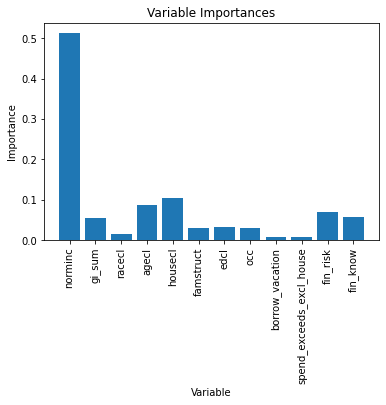

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from category_encoders import LeaveOneOutEncoder, TargetEncoder, OneHotEncoder, OrdinalEncoder, BinaryEncoder

def rf_regression(encoder=OneHotEncoder, dep_col = 'asset', df=df, x_cols=None):
    
    import warnings
    warnings.filterwarnings("ignore", message="is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead")
    
    df = df.copy()
    
    df['const'] = 1
    
    if x_cols is None:
        x_cols = [c for c in df.columns if c != dep_col]
    
    y = df[dep_col]

    enc = encoder()
    X = enc.fit_transform(df[x_cols], y)

    train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.3)

    rf = RandomForestRegressor()
    rf.fit(train_features, train_labels)

    # Set the style
    import matplotlib.pyplot as plt

    feature_list = list(X.columns)
    importances = list(rf.feature_importances_)# List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

    x_values = list(range(len(importances)))# Make a bar chart
    plt.bar(x_values, importances, orientation = 'vertical')# Tick labels for x axis
    plt.xticks(x_values, feature_list, rotation='vertical')# Axis labels and title
    plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

    return rf, rf.score(test_features, test_labels), feature_importances, X, y

x_cols = 'norminc racecl agecl housecl famstruct edcl occ borrow_vacation spend_exceeds_excl_house'.split()
x_cols = [
    'norminc',
    'housecl',
    'racecl',
    'famstruct',
    'occ',
    'borrow_vacation',
    'spend_exceeds_excl_house',
    'age_1',
    'age_2',
    'ed_1',
    'ed_2',
    'fin_risk',
    'shop_credit_2',
    'fin_know',
    'gi_sum',
    'indcat',
    'debt2inc']

x_cols = [
 'norminc',
 'homeeq', 
 'debt2inc',
 'debt',
 'age_1',
 'age_2',
 'agecl',
 'fin_know',
 'gi_sum',
 'occ',
 'shop_credit', 'shop_credit_2', 
 'fin_risk',
 'edcl',
 'racecl']

x_cols = ['norminc', 'gi_sum', 'racecl', 'agecl', 'housecl', 'famstruct', 
          'edcl', 'occ', 'borrow_vacation', 'spend_exceeds_excl_house', 'fin_risk', 'fin_know']

rf, score, fi, X, y = rf_regression(x_cols=x_cols, df=regr, encoder=TargetEncoder)
score

ValueError: too many values to unpack (expected 4)

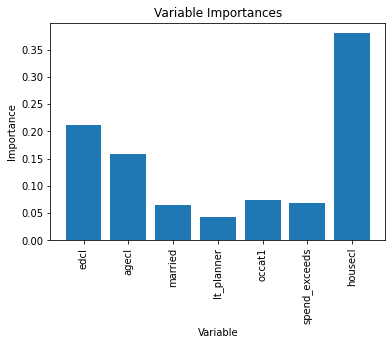

In [19]:
x_cols =  [ 'edcl','agecl', 'married','lt_planner','occat1', 'spend_exceeds', 'housecl']

rf, score, fi, X, y = rf_regression(x_cols=x_cols, df=regr, encoder=TargetEncoder)
score


In [ ]:
x_cols =  [ 'norminc', 'edcl','agecl', 'married','lt_planner','occat1', 'spend_exceeds', 'housecl']

score, fi, X, y = rf_regression(x_cols=x_cols, df=regr, encoder=TargetEncoder)
score

In [ ]:
dfs['normincpc'] = dfs.norminc/dfs.hhsize

In [ ]:
x_cols =  [ 'edcl','agecl', 'occat1', 'race', 'married' ]

score, fi, X, y = rf_regression(x_cols=x_cols, df=regr[regr.race=='white'], dep_col='nincpctle', encoder=TargetEncoder)
score

In [ ]:
x_cols =  [ 'edcl',  'agecl', 'occat1', 'race',  'housecl', 'married']

score, fi, X, y = rf_regression(x_cols=x_cols, df=regr, dep_col='norminc', encoder=TargetEncoder)
score

In [ ]:
x_cols =  [  'occat1',  'married', 'housecl', 'lifecl', 'edcl', 'agecl']

score, fi, X, y = rf_regression(x_cols=x_cols, df=regr, dep_col='norminc', encoder=TargetEncoder)
score

In [ ]:
fi

In [ ]:
x_cols =  [ 'edcl','agecl', 'occat1', 'race',  'housecl', 'married', 'lifecl' ]
enc = TargetEncoder(cols=x_cols)
y = regr['norminc']
X = enc.fit_transform(regr[x_cols], y)
X.describe().sort_values('std',axis=1)
    

In [ ]:
from sklearn.linear_model import ElasticNetCV

r = ElasticNetCV(cv=5, random_state=0)


r.fit(X, y)

print(r.alpha_)

print(r.intercept_)

r.score(X, y)

In [ ]:
dfs.groupby(['married']).normincpc.mean()

# Blinder-Oaxaca Decomposition

# Other Relationships

In [ ]:
dfs[['asset','debt','networth']].corr()

In [ ]:
dfs['homeeq_gtz'] = dfs.homeeq > 0
df['homeeq_gtz'] = df.homeeq > 0
dfs.groupby(['race']).homeeq_gtz.mean()

In [ ]:
dfs[dfs.homeeq_gtz].groupby(['race']).homeeq.mean()

In [ ]:
df[df.homeeq_gtz].groupby(['famstruct']).case_id.count()

In [ ]:
dfs.groupby(['race', dfs.networth > 0]).lt_planner.mean().unstack()

In [ ]:
# Races dont differ in debts
dfs.groupby(['race', dfs.gi_sum > 0]).debt.mean().unstack()

In [ ]:
# Races dont differ in debts
dfs.groupby(['race', dfs.gi_sum > 0]).debt.mean().unstack()

In [ ]:
dfs.groupby(['nincpctlecat']).saved.mean()

In [ ]:
# Saving distinguishes people with positive networths from negative networths most 
# in the middle incomes, and is not as predictive for the poorest and richest. 
t = dfs.groupby(['nincpctlecat', dfs.networth > 0]).saved.mean().unstack()
t = t[True] - t[False]
t.plot()


In [ ]:
dfs.debt2inc.describe()

In [ ]:
# Transfers have maybe 10% effect on debt
dfs.groupby([dfs.gi_sum > 0]).debt.mean()

In [ ]:
# Families that have recieved transfers have assets twice as large
t = dfs[dfs.age_1 < 45].copy()
t = t.groupby(['race',t.gi_sum > 0]).asset.median().unstack()
t['diff'] = t[True] - t[False]
t

In [ ]:
# But the also have larger incomes
t = dfs[dfs.age_1 < 45].copy()
t = t.groupby(['race',t.gi_sum > 0]).norminc.median().unstack()
t['diff'] = t[True] - t[False]
t

In [ ]:
# Whites and blacks hold similar amounts of debt, and debt to income, 
# across income ranges. 
dfs.groupby(['nincpctlecat', 'race']).mean()[['debt','debt2inc']].unstack()

In [ ]:
t = dfs[
    (dfs.age_1 < 50) & (dfs.age_1 > 40 ) & (dfs.homeeq > 0) 
]

t = t.groupby(['race','nincpctlecat']).asset.mean().unstack().T
t.columns = list(t.columns)
t['r'] = t.black / t.white

t

# White / Black Prediction


In [ ]:
t = regr[(regr.race=='white') & (regr.nincpctle < 90)]

m = ols('asset_ihs ~ norminc_ihs + gi_sum_ihs + C(agecl) + C(housecl) + C(famstruct) + C(edcl) + C(occ) ',
        data=t)

r = m.fit()

r.summary()

In [ ]:
t = regr[regr.race=='white']
p = np.sinh(r.predict(t))

def rmse(a, b):
    return np.sqrt(np.mean(np.square(a-b)))
    
rmse(p,t.asset)

In [ ]:
p.describe()

In [ ]:
(p - t.asset).hist(bins=100)

In [ ]:
rmse(t.asset,t.asset-( (np.random.standard_normal(len(t)))*10000))

In [ ]:
e = pd.Series((np.random.standard_normal(len(t))*10000))
e

In [ ]:
rmse(0,e)

In [28]:
t = pd.DataFrame({
    'const': 1,
    'a':np.random.standard_normal(1000)*10, 
    'b':np.random.standard_normal(1000)*10, 
    'c': np.random.random(1000)*10, 
    'd': np.random.randint(0,10, 1000), 
    'e': np.random.random(1000)*10, 
    
    'err': 0
    
})

d_map = { i:np.random.normal(150, 100) for i in range(10) }


rnd = (np.random.standard_normal(1000)/2) + 1

t['o'] = 5*t.a + 7*t.b + 13*t.c + t.d.map(d_map) +   100 

#t['err'] = np.random.standard_normal(1000)* (t.o/5)
#t['o'] = t.o + t.err

m = ols('o ~ a + b + c', data=t)

r = m.fit()

r.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      o   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     680.8
Date:                Thu, 17 Dec 2020   Prob (F-statistic):          1.22e-240
Time:                        08:08:36   Log-Likelihood:                -5598.8
No. Observations:                1000   AIC:                         1.121e+04
Df Residuals:                     996   BIC:                         1.123e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    260.7498      4.119     63.311      0.000     252.668     268.832
a              4.9196      0.206     23.923      0.000       4.516       5.323
b              7.2898      0.203     35.833      0.000       6.891       7.689
c             12.1270      0.721     16.811      0.000      10.711      13.543
==============================================================================
Omnibus:                       59.737   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.035
Skew:                          -0.064   Prob(JB):                     9.95e-06
Kurtosis:                       2.268   Cond. No.                         20.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
np.random.randint(0,10)

3

In [27]:
t.d.map(d_map)

0      171.234731
1      171.438343
2      136.803394
3       28.553094
4      136.557956
          ...    
995    136.803394
996    161.055418
997    153.978016
998    153.978016
999    161.055418
Name: d, Length: 1000, dtype: float64